* pertama buat cross validation buat modelnya
* grid search optimal parameter
* feature ablation dengan nambahin parameter baru ke function generate feature berupa feature mana yang mau dihilangkan dari dictionary
* error analysis tapi belum tau

### TO DO

* ~~untuk feature ablation caranya dengan cara buat baseline feature, terus tambahin suffix / prefix via dict update~~ **DONE!**
* ~~Terus mesti buat beberapa fold berbeda dengan cara ngubah random state dan save tiap model dengan tiap fold~~ **DONE!**


## Import Library

In [1]:
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
import scipy
from pathlib import Path

from joblib import dump, load
import pandas as pd

In [2]:
import sys

project_root = Path.cwd().parents[0]
data_path = project_root / 'data'
model_path = project_root / 'model'

src_dir = project_root / 'src'

sys.path.append(str(src_dir))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from utils import read_data
from visualization import plot_confusion_matrix

In [5]:
corpus_path = data_path / 'Indonesian_Manually_Tagged_Corpus.tsv'
tagged_sentences = read_data(corpus_path)

In [6]:
print("Number of Tagged Sentences ", len(tagged_sentences))
tagged_words = [tup for sent in tagged_sentences for tup in sent]
print("Total Number of Tagged words", len(tagged_words))
vocab = set([word for word, tag in tagged_words])
print("Vocabulary of the Corpus", len(vocab))
tags = set([tag for word, tag in tagged_words])
print("Number of Tags in the Corpus ", len(tags))

Number of Tagged Sentences  10030
Total Number of Tagged words 256622
Vocabulary of the Corpus 18287
Number of Tags in the Corpus  24


In [7]:
from collections import Counter 

Counter([tag for word, tag in tagged_words])

Counter({'CC': 7438,
         'CD': 17819,
         'DT': 381,
         'FW': 2365,
         'IN': 21311,
         'JJ': 9724,
         'MD': 5248,
         'NEG': 1520,
         'NN': 61940,
         'NND': 1414,
         'NNP': 34649,
         'OD': 738,
         'PR': 5348,
         'PRP': 7583,
         'RB': 4903,
         'RP': 183,
         'SC': 13080,
         'SYM': 2210,
         'UH': 30,
         'VB': 31733,
         'WH': 260,
         'X': 397,
         'Z': 26347,
         'fw': 1})

## First Model Iteration

### Generate All Model

In [64]:
from model import fit_and_dump, prepare_train_test

def run_all():
    pass

models = ['baseline', 'with-prefix', 'with-suffix', 'with-allfix']
# seeds = [42, 29, 12, 95, 2, 6]
seeds = [42, 29, 2, 6]
model_performance = {}
performance_df_list = []
for model in models:
    for index, seed in enumerate(seeds):
        model_name = f'crf-{model}-fold{index+1:02d}-seed{seed:02d}.joblib'
        path = model_path / model_name
        
        if not path.exists():
            # prepare training and test data
            X_train, y_train, X_test, y_test = prepare_train_test(tagged_sentences, seed, path)
        
            # fit data
            crf = fit_and_dump(X_train, y_train, path)
    
        crf = load(path)
        X_train, y_train, X_test, y_test = prepare_train_test(tagged_sentences, seed, path)
        print(f'{model_name} exists') 

        # evaluation
        y_pred = crf.predict(X_test)
        metric_dict = metrics.flat_classification_report(y_test, y_pred, 
                                                         labels=crf.classes_, digits=3, 
                                                         output_dict=True)
        performance_df = pd.DataFrame(metric_dict).T.reset_index().assign(model_name = model_name)
        performance_df_list.append(performance_df)
performance_dfs = pd.concat(performance_df_list).reset_index(drop=True).rename(columns={'index': 'tags_overall'})
performance_dfs['model_type'] = performance_dfs['model_name'].str.split('-fold').str[0]
performance_dfs.to_csv(model_path / 'model performance.csv', index=False)

crf-baseline-fold01-seed42.joblib exists


C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


crf-baseline-fold02-seed29.joblib exists
crf-baseline-fold03-seed02.joblib exists
crf-baseline-fold04-seed06.joblib exists
crf-with-prefix-fold01-seed42.joblib exists
crf-with-prefix-fold02-seed29.joblib exists
crf-with-prefix-fold03-seed02.joblib exists
crf-with-prefix-fold04-seed06.joblib exists
crf-with-suffix-fold01-seed42.joblib exists
crf-with-suffix-fold02-seed29.joblib exists
crf-with-suffix-fold03-seed02.joblib exists
crf-with-suffix-fold04-seed06.joblib exists
crf-with-allfix-fold01-seed42.joblib exists
crf-with-allfix-fold02-seed29.joblib exists
crf-with-allfix-fold03-seed02.joblib exists
crf-with-allfix-fold04-seed06.joblib exists


In [8]:
import seaborn as sns
import numpy as np

performance_dfs = pd.read_csv(data_path / 'model performance.csv')
data = performance_dfs.query("tags_overall == 'weighted avg'")
model_avg_f1 = data.groupby('model_type')['f1-score'].agg([np.mean, np.std]) * 100
model_avg_f1
# sns.boxplot('model_type', 'f1-score', data=data)

,mean,std
model_type,,
crf-baseline,71.726102,0.251751
crf-with-allfix,97.304530,0.093265
crf-with-prefix,95.384298,0.041855
crf-with-suffix,94.197502,0.091220


### Best Model Confusion Matrix

In [72]:
from model import fit_and_dump, prepare_train_test

path = model_path / 'crf-with-allfix-fold01-seed42.joblib'
crf = load(path)
seed = int(str(path).split('.')[0][-2:])
X_train, y_train, X_test, y_test = prepare_train_test(tagged_sentences, seed, path)
train_set, test_set = train_test_split(tagged_sentences, test_size=0.2, random_state=seed)

y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=crf.classes_, digits=3))

C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          IN      0.963     0.968     0.965      4096
          NN      0.970     0.974     0.972     12316
          JJ      0.949     0.948     0.948      1972
          PR      0.997     0.995     0.996      1111
           Z      0.998     0.998     0.998      5211
          CD      0.995     0.993     0.994      3591
         SYM      1.000     0.991     0.995       428
          VB      0.990     0.988     0.989      6371
          CC      0.988     0.979     0.983      1552
          RB      0.977     0.960     0.968      1007
          MD      0.993     0.985     0.989      1054
         PRP      0.997     0.994     0.996      1549
         NNP      0.951     0.964     0.958      6661
          SC      0.949     0.957     0.953      2601
         NND      0.939     0.906     0.922       255
          FW      0.916     0.810     0.860       458
         NEG      0.993     0.997     0.995       287
           X      0.800    

C:\Users\ANTHONI\Documents\kataai\src\visualization.py:20: RuntimeWarning: invalid value encountered in true_divide
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


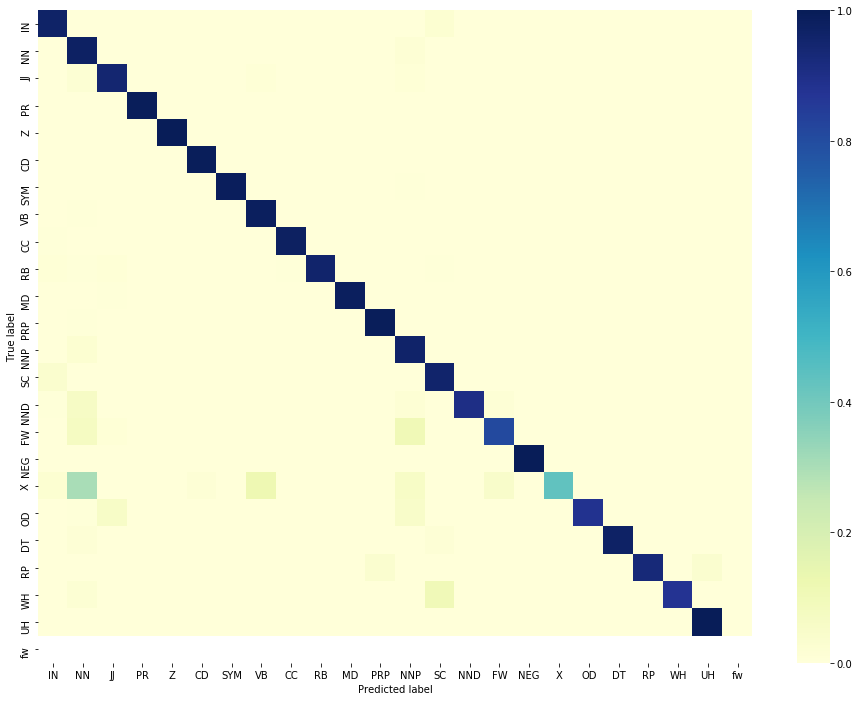

In [10]:
from visualization import plot_confusion_matrix

plot_confusion_matrix(y_test, y_pred, crf.classes_);

### Error analysis initial based on confusion matrix

In [11]:
# get sentence index for every tag
d = []
for index, sentence in enumerate(y_test):
    for tag in sentence:
        d.append((index, tag))

In [150]:
import pandas as pd
from utils import flatten


df = pd.DataFrame(d, columns=['sentence_index', 'y_test'])
df['y_pred'] = flatten(y_pred)
df['word'] = [word for sentence in test_set for word, _ in sentence]

# df[(df.y_test == 'X') & (df.y_pred == 'NN')]
# df[(df.y_test == 'X')]
# df[(df.y_test == 'WH') & (df.y_pred == 'SC')]
# df[(df.y_test == 'WH')].drop_duplicates(subset=['y_test', 'y_pred', 'word'])
# test_set[695]

In [73]:
df[df.word == 'antar']
# test_set[627]

,sentence_index,y_test,y_pred,word
15943,627,IN,IN,antar
46102,1816,IN,IN,antar


In [94]:
from model import prepare_data

In [171]:
from sklearn.metrics import confusion_matrix
def error_analysis(error_set):
    path = model_path / 'crf-with-allfix-fold01-seed42.joblib'
    crf = load(path)
    X_test, y_test = prepare_data(error_set, prefix=True, suffix=True)
    y_pred = crf.predict(X_test)
    words = [word for sent in error_set for word, _ in sent]
    return pd.DataFrame({'words': words, 'true label': y_test[0], 'predict label': y_pred[0]})

In [172]:
error_1 = [[('Nilai', 'NN'),
  ('tukar', 'VB'),
  ('rupiah', 'NN'),
  ('terhadap', 'IN'),
  ('dolar', 'NN'),
  ('AS', 'NNP'),
  ('di', 'IN'),
  ('pasar', 'NN'),
  ('spot', 'NNP'),
  ('antarnegara', 'X'),
  (',', 'Z'),
  ('Senin', 'NNP'),
  ('sore', 'NN'),
  ('melemah', 'VB'),
  ('lima', 'CD'),
  ('poin', 'NN')]]

In [173]:
error_analysis(error_1)

,predict label,true label,words
0,NN,NN,Nilai
1,VB,VB,tukar
2,NN,NN,rupiah
3,IN,IN,terhadap
4,NN,NN,dolar
5,NNP,NNP,AS
6,IN,IN,di
7,NN,NN,pasar
8,NNP,NNP,spot
9,NN,X,antarnegara


### precision, recall, and F1 scores

In [26]:
print(metrics.flat_classification_report(
    y_test, y_pred, labels=crf_model.classes_, digits=3
))

C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          IN      0.963     0.968     0.965      4096
          NN      0.970     0.974     0.972     12316
          JJ      0.949     0.948     0.948      1972
          PR      0.997     0.995     0.996      1111
           Z      0.998     0.998     0.998      5211
          CD      0.995     0.993     0.994      3591
         SYM      1.000     0.991     0.995       428
          VB      0.990     0.988     0.989      6371
          CC      0.988     0.979     0.983      1552
          RB      0.977     0.960     0.968      1007
          MD      0.993     0.985     0.989      1054
         PRP      0.997     0.994     0.996      1549
         NNP      0.951     0.964     0.958      6661
          SC      0.949     0.957     0.953      2601
         NND      0.939     0.906     0.922       255
          FW      0.916     0.810     0.860       458
         NEG      0.993     0.997     0.995       287
           X      0.800    

In [34]:
def metrics_evaluation(crf, y_test, y_pred):
    test_f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=crf.classes_)
    train_f1_score = metrics.flat_f1_score(y_train, y_pred_train, average='weighted', labels=crf.classes_)
    test_accuracy_score = metrics.flat_accuracy_score(y_test, y_pred)
    train_accuracy_score = metrics.flat_accuracy_score(y_train, y_pred_train)

    print(f'weighted f1 score test set: {test_f1_score}')
    print(f'weighted f1 score train set: {train_f1_score}')
    print(f'accuracy score test set: {test_accuracy_score}')
    print(f'accuracy score train set: {train_accuracy_score}')
    
metrics_evaluation(crf_model, y_test, y_pred)

C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


weighted f1 score test set: 0.9741426280108842
weighted f1 score train set: 0.9944000116957855
accuracy score test set: 0.9743383176468277
accuracy score train set: 0.9944052612903382


#### Confusion Matrix

#### Another Feature Ablation

In [36]:
from model import prepareData

X_train, y_train = prepareData(train_set)
X_test, y_test = prepareData(test_set)

In [117]:
crf_without_prefix = model_path / 'crf-without-prefix.joblib'
if crf_without_prefix.exists():
    crf_without_prefix = load(crf_without_prefix)
else:
    print(False)

crf_without_suffix = model_path / 'crf-without-suffix.joblib'
if crf_without_suffix.exists():
    crf_without_suffix = load(crf_without_suffix)
else:
    print(False)
    
crf_without_suffix = model_path / 'crf-without-anyfix.joblib'
if crf_without_suffix.exists():
    crf_without_suffix = load(crf_without_suffix)
else:
    print(False)

### Compare results

### Another feature extraction

In [48]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
        'is_first_word': i == 0,
        'is_last_word': i == len(sent)-1
    }
    
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [postag for token, postag in sent]

def sent2tokens(sent):
    return [token for token, postag in sent]

In [49]:
train_set, test_set = train_test_split(tagged_sentences, test_size=0.8, random_state=21)

In [ ]:
X_train = [sent2features(s) for s in train_set]
y_train = [sent2labels(s) for s in train_set]

X_test = [sent2features(s) for s in test_set]
y_test = [sent2labels(s) for s in test_set]

In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

In [ ]:
y_pred = crf.predict(X_test)
y_pred_train = crf.predict(X_train)

In [ ]:
print(metrics.flat_classification_report(
    y_test, y_pred, labels=crf.classes_, digits=3
))

#### Previous Metrics Used

In [0]:
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=crf.classes_)

0.9724534681067327

In [0]:
metrics.flat_f1_score(y_train, y_pred_train, average='weighted', labels=crf.classes_)

0.9945989057594046

In [0]:
metrics.flat_accuracy_score(y_test, y_pred)

0.9726862168931312

In [0]:
metrics.flat_accuracy_score(y_train, y_pred_train)

0.9946048580558065

In [0]:
print(metrics.flat_classification_report(
    y_test, y_pred, labels=crf.classes_, digits=3
))

              precision    recall  f1-score   support

          VB      0.991     0.988     0.989      6283
          CD      0.993     0.992     0.992      3587
          NN      0.969     0.974     0.971     12439
          IN      0.958     0.969     0.963      4160
          PR      0.997     0.993     0.995      1089
           Z      0.998     0.998     0.998      5200
          CC      0.988     0.977     0.983      1483
          MD      0.995     0.985     0.990      1034
          SC      0.948     0.949     0.949      2597
          JJ      0.943     0.944     0.944      1945
         PRP      0.999     0.992     0.995      1484
          RB      0.981     0.963     0.972       980
         NNP      0.947     0.960     0.953      6550
          FW      0.901     0.791     0.842       473
         NEG      0.993     0.993     0.993       282
         SYM      0.998     0.993     0.995       439
         NND      0.953     0.901     0.926       292
          OD      0.917    

## Hyperparameter Optimization

In [63]:
# crf = CRF(
#     algorithm='lbfgs',
#     c1=0.01,
#     c2=0.1,
#     max_iterations=100,
#     all_possible_transitions=True
# )
# crf.fit(X_train, y_train)

In [61]:
# labels = crf.classes_

# # define fixed parameters and parameters to search
# crf = CRF(
#     algorithm='lbfgs',
#     max_iterations=100,
#     all_possible_transitions=True
# )
# params_space = {
#     'c1': scipy.stats.expon(scale=0.5),
#     'c2': scipy.stats.expon(scale=0.05),
# }

# # use the same metric for evaluation
# f1_scorer = make_scorer(metrics.flat_f1_score,
#                         average='weighted', labels=labels)

# # search
# rs = RandomizedSearchCV(crf, params_space,
#                         cv=3,
#                         verbose=1,
#                         n_jobs=-1,
#                         n_iter=10,
#                         scoring=f1_scorer)
# rs.fit(X_train, y_train)

## Exploratory

In [0]:
tags = [tag for word, tag in tagged_words]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
plt.style.use('ggplot')
%matplotlib inline

In [0]:
keys, counts = np.unique(tags, return_counts=True)
c = Counter(tag for _, tag in tagged_words)
c.most_common()

<BarContainer object of 24 artists>

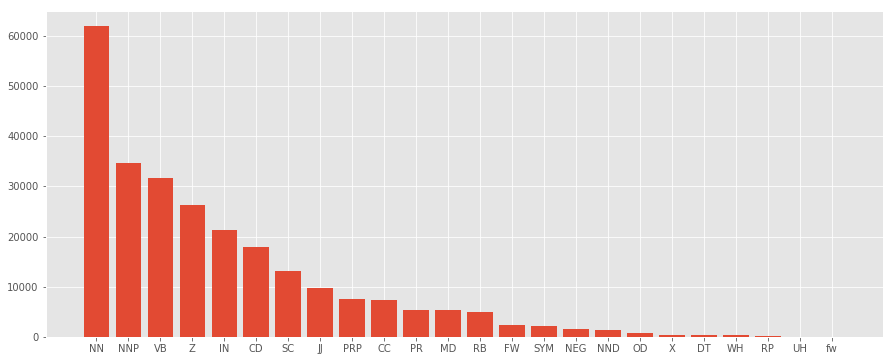

In [0]:
tags, counts = zip(*c.most_common())
plt.figure(figsize=(15, 6))
plt.bar(range(len(tags)), counts, tick_label=tags)

In [19]:
Counter(crf.transition_features_).most_common(20)

[(('FW', 'FW'), 5.516936),
 (('NNP', 'NNP'), 5.152914),
 (('NN', 'NN'), 3.269478),
 (('CD', 'NND'), 3.211954),
 (('NND', 'NN'), 2.897334),
 (('FW', 'X'), 2.748798),
 (('NND', 'NND'), 2.703739),
 (('NN', 'JJ'), 2.642689),
 (('VB', 'NN'), 2.511993),
 (('CD', 'NN'), 2.49331),
 (('MD', 'VB'), 2.442513),
 (('IN', 'NN'), 2.358871),
 (('DT', 'NN'), 2.053309),
 (('NN', 'FW'), 2.036776),
 (('SC', 'NN'), 1.907815),
 (('NN', 'X'), 1.887867),
 (('RB', 'JJ'), 1.880881),
 (('X', 'X'), 1.79022),
 (('SC', 'VB'), 1.782318),
 (('PRP', 'VB'), 1.740089)]

In [20]:
Counter(crf.transition_features_).most_common()[-20:]

[(('NEG', 'PRP'), -1.375597),
 (('CC', 'OD'), -1.402652),
 (('NEG', 'NNP'), -1.42966),
 (('OD', 'RB'), -1.469423),
 (('CD', 'NEG'), -1.474596),
 (('NEG', 'CC'), -1.502176),
 (('RB', 'CC'), -1.524955),
 (('IN', 'NEG'), -1.570749),
 (('MD', 'PR'), -1.611159),
 (('PRP', 'PRP'), -1.624314),
 (('PRP', 'WH'), -1.662496),
 (('NNP', 'WH'), -1.687422),
 (('WH', 'IN'), -1.778916),
 (('NEG', 'RP'), -1.871366),
 (('WH', 'MD'), -1.991228),
 (('SC', 'OD'), -2.077336),
 (('IN', 'IN'), -2.115241),
 (('MD', 'SC'), -2.20288),
 (('IN', 'CC'), -2.649923),
 (('IN', 'MD'), -2.992268)]

In [23]:
Counter(crf.state_features_).most_common(100)

[(('suffix_4:mnya', 'SC'), 7.166967),
 (('prefix_4:bers', 'IN'), 6.606277),
 (('suffix_4:mang', 'RB'), 6.503894),
 (('suffix_4:gkah', 'NN'), 6.097586),
 (('prefix_3:ber', 'VB'), 5.976196),
 (('is_first_capital', 'NNP'), 5.950854),
 (('suffix_4:rsen', 'CD'), 5.744871),
 (('is_complete_capital', 'Z'), 5.160597),
 (('prefix_2:di', 'VB'), 5.121556),
 (('prefix_4:berb', 'CD'), 4.999486),
 (('suffix_4:rsih', 'JJ'), 4.891152),
 (('prefix_4:akan', 'MD'), 4.778009),
 (('prefix_4:menj', 'IN'), 4.762523),
 (('suffix_4:adak', 'RB'), 4.742228),
 (('suffix_4:hkan', 'RB'), 4.721474),
 (('suffix_4:urut', 'IN'), 4.675095),
 (('suffix_4:pada', 'IN'), 4.670698),
 (('prefix_4:sama', 'JJ'), 4.653576),
 (('suffix_4:enai', 'IN'), 4.634499),
 (('suffix_4:agai', 'IN'), 4.622229),
 (('prefix_4:utan', 'NN'), 4.606658),
 (('prefix_4:puny', 'VB'), 4.600435),
 (('prefix_4:ters', 'PR'), 4.562902),
 (('prefix_4:dana', 'NN'), 4.52665),
 (('suffix_4:dian', 'CC'), 4.473657),
 (('suffix_4:sung', 'RB'), 4.470662),
 (('suf

## Reports

### The Model

A machine learning based model to perform POS tagging automatically is build using Conditional Random Field (CRF), which is type of probabilistic graphical model that can be used to model sequential data, such as labels of words in a sentence. CRF is commonly used method for application in many areas, including natural language processing, computer vision, and bioinformatics.
In CRF, we will design a set of feature functions to extract features for each word in a sentence. During model training, CRF will try to determine the weights of different feature functions that will maximise the likelihood of the labels in the training data. In this project, we use an open source library, `sklearn-crfsuite`, as an implentation of CRF model.

We generate feature function as dictionary format because `sklearn-crfsuite` accept input in dictionary format. feature design greatly affects the labeling accuracy. Below are some of features for a word in POS tagging:

* The word position (first word or last word)
* Whether the word first letter is capitalised
* The prefix/suffix of word
* The words surrounding, such as the previous and the next word
* Whether word is in uppercase or lowercase
* Whether word is a number, or contains digits
* Whether word is or contains a special character (such as hyphen)

### Evaluation

There's mislabel sentences, which is fw with lowercase instead of FW with uppercase

to improve performance of the model, we could add grammar and lexicon of bahasa Indonesia to increase accuracy of tagging by remove ambiguity and relation among lexical item. 

Some more advanced techniques can be used for improving model accuracy. For example some attributes of neighbors can be added to features(if previous token is number probability of current token being noun is bigger, maybe :

#### Model Features

In [16]:
crf_initial_features = {
                        'is_first_capital':int(sentence[index][0].isupper()),
                        'is_first_word': int(index == 0),
                        'is_last_word':int(index == len(sentence)-1),
                        'is_complete_capital': int(sentence[index].upper() == sentence[index]),
                        'prev_word':'' if index == 0 else sentence[index-1],
                        'next_word':'' if index == len(sentence)-1 else sentence[index+1],
                        'is_numeric':int(sentence[index].isdigit()),
                        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])', sentence[index])))),
                        'prefix_1':sentence[index][0],
                        'prefix_2': sentence[index][:2],
                        'prefix_3':sentence[index][:3],
                        'prefix_4':sentence[index][:4],
                        'suffix_1':sentence[index][-1],
                        'suffix_2':sentence[index][-2:],
                        'suffix_3':sentence[index][-3:],
                        'suffix_4':sentence[index][-4:],
                        'word_has_hyphen': 1 if '-' in sentence[index] else 0 
                         }

crf_without_suffix_features = {
                        'is_first_capital':int(sentence[index][0].isupper()),
                        'is_first_word': int(index == 0),
                        'is_last_word':int(index == len(sentence)-1),
                        'is_complete_capital': int(sentence[index].upper() == sentence[index]),
                        'prev_word':'' if index == 0 else sentence[index-1],
                        'next_word':'' if index == len(sentence)-1 else sentence[index+1],
                        'is_numeric':int(sentence[index].isdigit()),
                        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])', sentence[index])))),
                        'prefix_1':sentence[index][0],
                        'prefix_2': sentence[index][:2],
                        'prefix_3':sentence[index][:3],
                        'prefix_4':sentence[index][:4],
                        'word_has_hyphen': 1 if '-' in sentence[index] else 0 
                         }

crf_without_prefix_features = {
                        'is_first_capital':int(sentence[index][0].isupper()),
                        'is_first_word': int(index == 0),
                        'is_last_word':int(index == len(sentence)-1),
                        'is_complete_capital': int(sentence[index].upper() == sentence[index]),
                        'prev_word':'' if index == 0 else sentence[index-1],
                        'next_word':'' if index == len(sentence)-1 else sentence[index+1],
                        'is_numeric':int(sentence[index].isdigit()),
                        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])', sentence[index])))),
                        'suffix_1':sentence[index][-1],
                        'suffix_2':sentence[index][-2:],
                        'suffix_3':sentence[index][-3:],
                        'suffix_4':sentence[index][-4:],
                        'word_has_hyphen': 1 if '-' in sentence[index] else 0 
                         }

crf_without_anyfix_features = {
                        'is_first_capital':int(sentence[index][0].isupper()),
                        'is_first_word': int(index == 0),
                        'is_last_word':int(index == len(sentence)-1),
                        'is_complete_capital': int(sentence[index].upper() == sentence[index]),
                        'prev_word':'' if index == 0 else sentence[index-1],
                        'next_word':'' if index == len(sentence)-1 else sentence[index+1],
                        'is_numeric':int(sentence[index].isdigit()),
                        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])', sentence[index])))),
                        'word_has_hyphen': 1 if '-' in sentence[index] else 0 
                         }

NameError: name 'sentence' is not defined

#### Old Feature Ablation

In [46]:
def feature_ablation(d, entriesToRemove = None):
    for k in entriesToRemove:
        d.pop(k, None)
    return d
      
def features(sentence, index, entriesToRemove = None):
    ### sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    ### and entriestoRemove type is tuple
    d = {
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index == 0),
        'is_last_word':int(index == len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper() == sentence[index]),
        'prev_word':'' if index == 0 else sentence[index-1],
        'next_word':'' if index == len(sentence)-1 else sentence[index+1],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])', sentence[index])))),
        'prefix_1':sentence[index][0],
        'prefix_2': sentence[index][:2],
        'prefix_3':sentence[index][:3],
        'prefix_4':sentence[index][:4],
        'suffix_1':sentence[index][-1],
        'suffix_2':sentence[index][-2:],
        'suffix_3':sentence[index][-3:],
        'suffix_4':sentence[index][-4:],
        'word_has_hyphen': 1 if '-' in sentence[index] else 0 
         }
    
    if not entriesToRemove:
        return d
    else:
        return feature_ablation(d, entriesToRemove)
                
def untag(sentence):
      return [word for word, tag in sentence]


def prepareData(tagged_sentences, entriesToRemove):
    X, y = [], []
    for sentences in tagged_sentences:
        X.append([features(untag(sentences), index, entriesToRemove) for index in range(len(sentences))])
        y.append([tag for word, tag in sentences])
    return X, y

suffix_removed = tuple(['suffix_1', 'suffix_2', 'suffix_3', 'suffix_4'])
prefix_removed = tuple(['prefix_1', 'prefix_2', 'prefix_3', 'prefix_4'])
anyfix_removed = tuple(['prefix_1', 'prefix_2', 'prefix_3', 'prefix_4', 'suffix_1', 'suffix_2', 'suffix_3', 'suffix_4'])
X_train, y_train = prepareData(train_set, anyfix_removed)
X_test, y_test = prepareData(test_set, anyfix_removed)